<div class="alert alert-block alert-info">
<b>Note:</b> If running a big enough sample, you'll need to start jupyter with the following:
<br><br>
    $ jupyter notebook --NotebookApp.iopub_data_rate_limit=1e10
</div>

# Intro

The following notebook is a compilation of results extracted from the deep guide demo. The demo source code can be found 
<a href="https://github.com/Zerfalex/Deep-Guide-Web">here</a> 
and the demo itself can be played 
<a href="https://zerfalex.github.io/Deep-Guide-Web/">here</a>
.


Every new player was assigned a random 5 letter hash for identification.
+++ 
The data was collected in JSON format, with the following catagories:

* Sorted: player > Game Number > Game Round > Round Data
* Unsorted: randomHash > Round Data
* Metrics, how many times someone got to round n
* Progression: each player's score each game
* Stats: Players and Wins



The round data has the following attributes:

~~~
{
    "name": player hash
    
    "packName": soundpack name
    "distance": sound distance
    "radius": sound radius
    "axis": (UP-DOWN/FRONT-BACK)
    "soundName": sound file name
    "hrtf": hrtf file name

    "deviceType": (HEADPHONES/EARBUDS/OTHER)
    "deviceName": optional device name

    "trueRound": Round Number, losses included
    "gameRound": Round Number, without losses
    "gameNumber": Game Number

    "buttonPressed": Which button the player pressed
    "soundPlaying": Correct button, where the sound is playing

    "correctX": If player was correct horizontally
    "correctY": If player was correct vertically
    "correct": If player was right

    "totalRounds": Round number across all games
    "totalCorrectX": Number of correctXs across all games
    "totalCorrectY": Number of correctYs across all games
    "totalCorrects": Number of corrects across all games

    "elapsed": Time to press button, seconds
}
~~~

## Table of Contents:
* [Variables](#variables)
* [Aux Functions](#aux-functions)
* [Stats Functions](#stats-functions)
* [Math Functions](#math-functions)

## Imports

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

import decimal
import functools
import statistics
import time
import math

## Variables <a class="anchor" id="variables"></a>

In [2]:
jsonStatsPath = "sample1"
soundPack = "2_8_DU_phone3shorter_irc_1037"

## Aux Functions <a class="anchor" id="aux-functions"></a>

In [3]:
def getJson(filePath):
    filePath = str(filePath) + ".json"
    with open(filePath) as file:
        jsonObj = json.load(file)
    return jsonObj

def isListOfLists(values):
    return any(isinstance(value, list) for value in values)

#[[1,2,3],[2,4,3]] -> [1.5,3,3]
def concatListMean(values):
    return np.mean(values, axis=0)

#[1,2,3,4,5,7] 2 -> [1.5, 2.5, 3.5, 4.5, 6]
def slidingWindow(values, windowSize):
    window = []
    if isListOfLists(values):
        for value in values:
            window.append(slidingWindow(value, windowSize))
    else:
        for i in range(len(values)-windowSize):
            windowAverage = np.mean(values[i:i+windowSize])
            window.append(windowAverage)
    return window

def plotList(values, title):
    fig = plt.figure()
    fig.text(0.5, 1, title, ha='center')
    if isListOfLists(values):
        for value in values:
            plt.plot(range(len(value)), value)
    else:
        plt.plot(range(1,len(values)+1),values)

def plotList2(values, title, labels=None, start=1):
    fig = plt.figure()
    fig.text(0.5, 1, title, ha='center')
    
    if labels is None:
        if isListOfLists(values):
            for value in values:
                plt.plot(range(start,len(value) + start), value)
        else:
            plt.plot(range(start,len(values) + start),values)
    else:
        #labels = list(map(lambda x: str(x), labels))
        if isListOfLists(values):
            for value in values:
                plt.plot(labels[:len(value)], value)
        else:
            plt.plot(labels,values)
    

def printl(lst, vals=20, chars=100, sep='\n', end='\n'):
    print(*list(map(lambda x: str(x)[:chars-3], lst[:vals])), sep=sep, end=end)
    
def printb(blst):
    for i,b in enumerate(blst):
        print(b, end='\t', sep='>')
        if ((i+1)%3 == 0): print('')
            
            

In [4]:
t_start = None
t_prev = None
t_cur = None
def startTime():
    global t_start, t_prev
    
    t_start = time.time()
    t_prev = t_start
    
def elapsedTime():
    global t_cur,t_prev
    
    t_cur = time.time()
    r = t_cur - t_prev
    t_prev = t_cur
    return r
    
def totalElapsedTime():
    return time.time() - t_start

## Stats Functions  <a class="anchor" id="stats-functions"></a>

In [5]:
#Gets all scores for each player or gets X scores for players with at least X games
def getScores(jsonStats, minGames = -1):
    scores = []
    progStats = jsonStats["progression"][soundPack]
    for player in progStats:
        playerScores = list(progStats[player].values())
        playerGames = len(playerScores)
        if minGames<0:
            scores.append(playerScores)
        elif playerGames>=minGames:
            scores.append(playerScores[0:minGames])
    return scores

def getUnsortedRounds(jsonStats):
    r = list(jsonStats['unsorted'].values())
    return r

def getSortedByButton(jsonStats):
    r = [[] for i in range(9)]
    for v in getUnsortedRounds(jsonStats):
        r[v['soundPlaying']].append(v)
    return r

def getDetails(uRounds):
    users = []
    r = {
        'maxRounds': 0,
        'maxGames': 0,
        'headphones': 0,
        'earbuds': 0,
    }
    for v in uRounds:
        r['maxRounds'] = max(r['maxRounds'], v['totalRounds'])
        r['maxGames'] = max(r['maxGames'], v['gameNumber'])
        #unique
        if v['name'] not in users:
            r[v['deviceType']] += 1
            users.append(v['name'])
        
    return r

## Math Functions <a class="anchor" id="math-functions"></a>

In [6]:
def portion(a, *b, inc=True):
    try:
        return a /(a + sum(b))
    except ZeroDivisionError as e:
        return 0


def percent(val, dec=1):
    return str(round(val * 100, dec)) + '%'
  
#returns rounded mean
def meanr(lst, dec = 1):
    return round(statistics.mean(lst), dec)

#returns rounded median
def medianr(lst, dec = 1):
    return round(statistics.median(lst), dec)

#returns rounded median
def moder(lst, dec = 1):
    return round(statistics.mode(lst), dec)

def doubleR(lst, dec = 1):
    if isListOfLists(lst):
        mean, median = [],[]
        for v in lst:
            r = doubleR(v, dec=dec)
            mean.append(r[0])
            median.append(r[1])
        return (mean, median)
    else:
        return (round(statistics.mean(lst), dec),
                round(statistics.median(lst), dec))

def tripleR(lst, dec = 1):
    if isListOfLists(lst):
        mean, median, mode = [],[],[]
        for v in lst:
            r = tripleR(v, dec=dec)
            mean.append(r[0])
            median.append(r[1])
            mode.append(r[2])
        return (mean, median, mode)
    else:
        return (round(statistics.mean(lst), dec),
                round(statistics.median(lst), dec),
                round(statistics.mode(lst), dec))


# Main

In [7]:
jsonStats = getJson('sample7')

uRounds = getUnsortedRounds(jsonStats)
#filter out other listening devices(speakers, etc)
uRounds = list(filter(lambda x: x['deviceType'] != 'other', uRounds))
details = getDetails(uRounds)
print(details)



{'maxRounds': 1154, 'maxGames': 155, 'headphones': 355, 'earbuds': 169}


## General

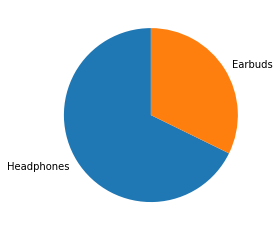

Accuracy per device:
Headphones: 55.0%
Earbuds: 52.0%
For a difference of 3.0%


In [8]:
plt.pie([details['headphones'], details['earbuds']], labels = ['Headphones', 'Earbuds'], startangle=90)

plt.show()

accs = {'headphones': [], 'earbuds': []}

for r in uRounds:
    accs[r['deviceType']].append(r['correct'])
    
h = meanr(accs['headphones'], dec=2)
e = meanr(accs['earbuds'], dec=2)

#plt.pie([accs['headphones'], accs['earbuds']], labels = ['Headphones', 'Earbuds'], startangle=90)


print(f'Accuracy per device:\nHeadphones: {percent(h)}\nEarbuds: {percent(e)}\nFor a difference of {percent(abs(e-h))}')

## Speed

#### Global Speed & Speed Per Button

In [9]:
globalSpeedMean = meanr(map(lambda x: x['elapsed'], uRounds), dec=2)
globalSpeedMedian = medianr(map(lambda x: x['elapsed'], uRounds), dec=2)
#nature of game doesnt punish slowness
print('Global Speed Mean: ' + str(globalSpeedMean))
print('Global Speed Median: ' + str(globalSpeedMedian))
print()

speedPerButton = list(map(lambda x: list(map(lambda y: y['elapsed'], x)),getSortedByButton(jsonStats)))

Global Speed Mean: 2.42
Global Speed Median: 1.69



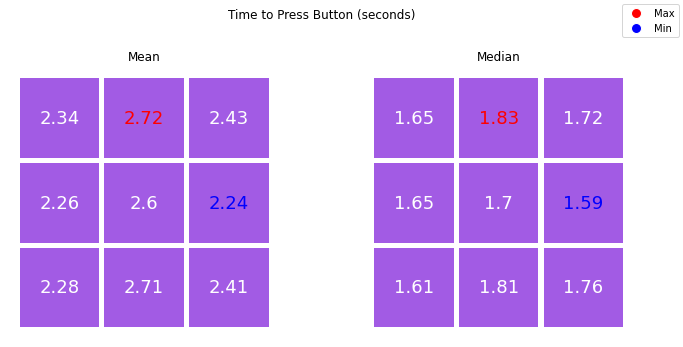

In [32]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

def addButton(ax, size, x, y, text='text', color = '#A25BE4', textColor = 'white', radius=2):
    rectangle =  plt.Rectangle((x,y), size, size, fc=color, capstyle='round')
    half = size/2
    ax.text(x+half, y+half, text, 
            horizontalalignment='center',verticalalignment='center', 
            color=textColor, fontsize=18)
    ax.add_patch(rectangle)

def addButtons(ax, size, values, title, margin=1, extra=True):
    if extra:
        P = values.index(max(values))
        p = values.index(min(values))
    x,y = 0,0
    pos = -1
    for i in range(3)[::-1]:
        y += margin 
        for j in range(3):
            x += margin
            pos = i*3+j
            c = 'red' if pos == P else 'blue' if pos == p else 'white'
            addButton(ax, size, x, y, text=values[pos], textColor = c)
            x += size
        x = 0
        y += size
    ax.axis('off')
    ax.axis('scaled')
    ax.set_title(title)

(buttonSpeedMean,buttonSpeedMedian) = doubleR(speedPerButton, dec = 2)    

fig, axs = plt.subplots(1, 2)

addButtons(axs[0], 3, buttonSpeedMean, title='Mean', margin=0.2)
addButtons(axs[1], 3, buttonSpeedMedian, title='Median',  margin=0.2)
#addButtons(axs[2], 3, buttonSpeedMode, title='Mode',  margin=0.2)

fig.set_figwidth(10)
fig.set_figheight(5)
fig.tight_layout(rect=[0, 0.03, 1, 0.87])
fig.suptitle('Time to Press Button (seconds)')

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Max',markerfacecolor='r', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Min',markerfacecolor='b', markersize=10),
                ]

fig.legend(handles=legend_elements, fontsize=10)

plt.show()

#### Speed-Accuracy Correlation

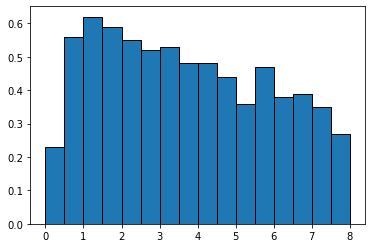

In [11]:
#Speed-Accuracy Correlation


interval = 0.5
lim = 8

buckets = math.ceil((lim / interval))

accuracies = [[] for _ in range(buckets)]

for r in uRounds:
    bucket = math.floor(r['elapsed'] / interval)
    if bucket < buckets:
        accuracies[bucket].append(r['correct'])

accuracy = list(map(lambda x: meanr(x, dec=2), accuracies))
times = list(map(lambda x: x * interval, range(buckets)))



plt.bar(times, height = accuracy, width = interval, align='edge', edgecolor='black')

plt.show()

#### Speed progression over Games/Rounds

In [12]:
#Lists of median/mean speed per totalRounds/Games

#limits
roundLimit = 100
gameLimit = 30

#makes ranges based on limit(unless there's fewer than)
roundRange = range(min(roundLimit, details['maxRounds']) + 1)
gameRange = range(min(gameLimit, details['maxGames']) + 1)

rounds = list(roundRange)
games = list(gameRange)

#empty list of lists to hold values for every speed per game/round
speedsPerRound = [[] for _ in roundRange]
speedsPerGame = [[] for _ in gameRange]

#fills lists checking for the limit correspondingly
for v in uRounds:
    rnd = v['totalRounds']
    game = v['gameNumber']
    elapsed = v['elapsed']
    
    if rnd <= roundLimit:
        speedsPerRound[rnd].append(elapsed)
    if game <= gameLimit:
        speedsPerGame[game].append(elapsed)
        
#first element is zero since no round 0
meanSpeedsPerRound = [0]
medianSpeedsPerRound = [0]
meanSpeedsPerGame = [0]
medianSpeedsPerGame = [0]

#fills mean/median lists with values from above
for speeds in speedsPerRound[1:]:
    meanSpeedsPerRound.append(meanr(speeds))
    medianSpeedsPerRound.append(medianr(speeds))
    
for speeds in speedsPerGame[1:]:
    meanSpeedsPerGame.append(meanr(speeds))
    medianSpeedsPerGame.append(medianr(speeds))


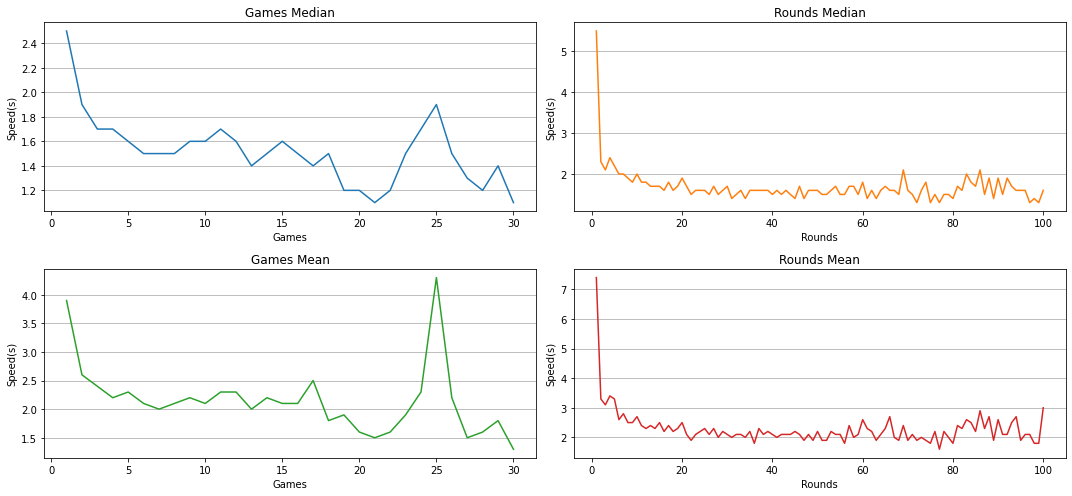

In [13]:
fig, axs = plt.subplots(2, 2)

for ax in axs.flat[::2]:
    ax.set(xlabel='Games', ylabel='Speed(s)')
    ax.grid(color='gray', linestyle='-', linewidth=0.5, axis='y')
    
for ax in axs.flat[1::2]:
    ax.set(xlabel='Rounds', ylabel='Speed(s)')
    ax.grid(color='gray', linestyle='-', linewidth=0.5, axis='y')

axs[0, 0].plot(games[1:], medianSpeedsPerGame[1:])
axs[0, 0].set_title('Games Median')
axs[0, 1].plot(rounds[1:], medianSpeedsPerRound[1:], 'tab:orange')
axs[0, 1].set_title('Rounds Median')
axs[1, 0].plot(games[1:], meanSpeedsPerGame[1:], 'tab:green')
axs[1, 0].set_title('Games Mean')
axs[1, 1].plot(rounds[1:], meanSpeedsPerRound[1:], 'tab:red')
axs[1, 1].set_title('Rounds Mean')

# Hide x labels and tick labels for top plots and y ticks for right plots.

    
fig.set_figwidth(15)
fig.set_figheight(7)
fig.tight_layout()

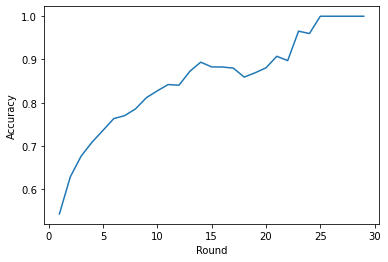

In [14]:
#Accuracy after n perfect rounds
maxRounds = 30

def perfectUntil(rnd):
    users = {}

    for r in uRounds:
        tr = r['trueRound']
        if tr == rnd and tr == r['gameRound']:
            name = r['name']
            game = r['gameNumber']

            if name not in users:
                users[name] = set()
            users[name].add(game)



    f = filter(lambda x: x['name'] in users and x['gameNumber'] in users[x['name']] and x['trueRound'] >= rnd, uRounds)

    return list(f)

tally = []
for i in range(1,maxRounds):
    tally.append(meanr(list(map(lambda x: x['correct'], perfectUntil(i))), dec = 4))

plt.plot(range(1,maxRounds), tally)
#Round reached without failing once
plt.xlabel('Round')
#Accuracy after reaching said round e.g. accuracy after 5 no miss rounds
plt.ylabel('Accuracy')
plt.show()




In [15]:
#global accuracy


l = list(map(lambda x: x['correct'], uRounds))

print(len(uRounds))

print(tripleR(l, dec=4))

18421
(0.5428, 1, 1)


In [16]:
test = {
    'a':5
}

if False and test['b']:
    print('f')

In [17]:
bts = [0]*9
for i in range(0,9):
    bts[i] = {True:0, False:0}
j = 0
for v in getUnsortedRounds(jsonStats):
    if (v['deviceType'] == 'default'): j += 1
    bts[v['soundPlaying']][v['correct']] += 1
    
print(bts)

[{True: 1123, False: 1140}, {True: 1001, False: 1494}, {True: 1141, False: 1212}, {True: 1290, False: 801}, {True: 964, False: 1584}, {True: 1329, False: 667}, {True: 1238, False: 820}, {True: 1158, False: 1179}, {True: 1255, False: 866}]


In [18]:
#Accuracy per button
for i,b in enumerate(bts):
    print(percent(portion(b[True], b[False])), end='\t', sep='>')
    if ((i+1)%3 == 0): print('')
    


49.6%	40.1%	48.5%	
61.7%	37.8%	66.6%	
60.2%	49.6%	59.2%	


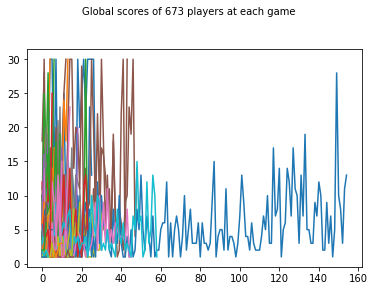

In [19]:
scores = getScores(jsonStats)
plotList2(scores, "Global scores of " + str(len(scores)) + " players at each game", start = 0)

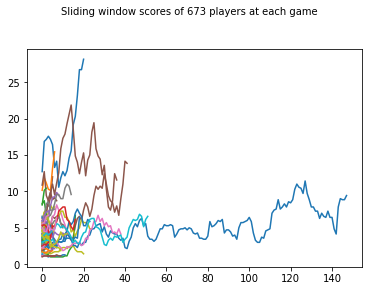

In [20]:
scores = getScores(jsonStats)
averagedWindowScores = slidingWindow(scores, 7)
plotList(averagedWindowScores, "Sliding window scores of " + str(len(scores)) + " players at each game")

[2.609375 4.21875  4.078125 4.53125  4.234375 4.46875  4.046875 5.34375
 4.828125 4.9375  ]


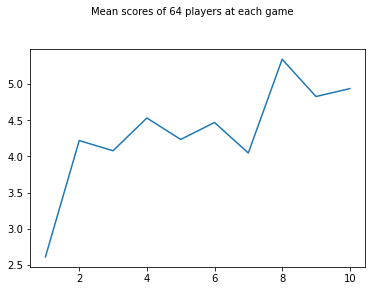

In [21]:
scores = getScores(jsonStats, minGames = 10)
averagedScores = concatListMean(scores)
print(averagedScores)
plotList(averagedScores, "Mean scores of " + str(len(scores)) + " players at each game")